#Wine dataset 분류

##3주차 과제
저번주에 진행했던 분석을 새로 배운 것들 위주로 고쳐보기




**- 데이터 분석 목표**  
sklearn에서 제공하는 wine 데이터셋 활용; 13가지 features를 가진 데이터를 통해 3가지 label로 분류(Classification)  

**- auc =  0.9491525423728814**  

**- 기존 코드에서 바꿔본 내용** 
 - custom dataset class로 정의, dataloader; batch_size = 6
 - 모델 class로 구현; 활성화 함수로 sigmoid함수 말고 ReLU 함수 사용
 - 가중치 초기화 방법으로 He initialization 방법 사용
 - optimizer 방법 기존의 SGD에서 Adam으로 변경; learning rate 또한 0.05에서 0.01로 변경하였음



In [ ]:
import torch
from torch import nn, optim
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd

In [ ]:
from torch.utils.data import Dataset            #data를 정의
from torch.utils.data import DataLoader         #배치 iteration을 손쉽게 함
from torch.utils.data import TensorDataset

PyTorch의 Dataset과 DataLoader를 이용하면 학습을 위한 방대한 데이터를 미니배치 단위로 처리할 수 있고 데이터를 무작위로 섞음으로써  
학습의 효율성을 향상시킬 수 있다. 또한 데이터를 여러개의 GPU를 사용해 병렬처리로 학습할 수도 있다.

In [ ]:
#연산 방법 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#for reproducibility
torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)

In [ ]:
#데이터 불러오기
wine = load_wine()
wine

{'DESCR': '.. _wine_dataset:\n\nWine recognition dataset\n------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 178 (50 in each of three classes)\n    :Number of Attributes: 13 numeric, predictive attributes and the class\n    :Attribute Information:\n \t\t- Alcohol\n \t\t- Malic acid\n \t\t- Ash\n\t\t- Alcalinity of ash  \n \t\t- Magnesium\n\t\t- Total phenols\n \t\t- Flavanoids\n \t\t- Nonflavanoid phenols\n \t\t- Proanthocyanins\n\t\t- Color intensity\n \t\t- Hue\n \t\t- OD280/OD315 of diluted wines\n \t\t- Proline\n\n    - class:\n            - class_0\n            - class_1\n            - class_2\n\t\t\n    :Summary Statistics:\n    \n    ============================= ==== ===== ======= =====\n                                   Min   Max   Mean     SD\n    ============================= ==== ===== ======= =====\n    Alcohol:                      11.0  14.8    13.0   0.8\n    Malic Acid:                   0.74  5.80    2.34  1.12\n    Ash:           

In [ ]:
pd.DataFrame(wine.data, columns = wine.feature_names)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [ ]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [ ]:
#input, output 데이터 설정
input = wine.data
output = wine.target

#train, test data split
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size = 0.33, random_state=42, stratify=wine.target, shuffle = True)

#데이터를 텐서로 바꾸고 gpu 연산이 가능하도록 gpu에 옮김
#X_train = torch.FloatTensor(X_train).to(device)
#y_train = torch.LongTensor(y_train).to(device)
#X_test = torch.FloatTensor(X_test)
#y_test = torch.LongTensor(y_test)

In [ ]:
print(len(X_train))
print(len(X_test))

119
59


In [ ]:
print(X_train[0])
print(y_train[0])

[1.375e+01 1.730e+00 2.410e+00 1.600e+01 8.900e+01 2.600e+00 2.760e+00
 2.900e-01 1.810e+00 5.600e+00 1.150e+00 2.900e+00 1.320e+03]
0


**input 변수가 13개!  
  y의 class 종류가 3개!**

#Custom Dataset 정의

**Dataset class는 전체 dataset을 구성하는 단계; 3가지 기억하자!!**  
 - init : class에서 객체가 생성되면 바로 실행되는 함수
 - len : observation 수를 정의하는 함수
 - getitem : iteration마다 해당하는 데이터를 돌려주는 함수  


len의 경우 x_data나 y_data는 길이가 같으니까 아무 length나 return하면 된다  
getitem의 경우 index번째 data를 return 하도록 코드를 짜야한다 이때 tensor를 return 해야한다

In [ ]:
class CustomDataset(Dataset):
  def __init__(self):

    self.x_data = X_train
    self.y_data = [[y] for y in y_train]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x,y

torch.utils.data.Dataset을 상속 받아 직접 커스텀 데이터셋을 만드는 과정이다  
torch.utils.data.Dataset은 파이토치에서 데이터셋을 제공하는 추상 클래스이다

In [ ]:
print(X_train.ndim)

2


In [ ]:
print(y_train.ndim)

1


list comprehension을 써서 y_data를 2차원으로 만든다  
나중에 loss를 계산하기 위해 squeeze를 해야하긴 하지만 getitem을 통해 [숫자] 형태로 가져오기 위함이다  
결국 y data는 이용 될때는 1차원 벡터로 바뀌지만 이용하기 위해서는 2차원(리스트 안의 리스트) 형태로 만들어줘야 한다

**X_train과 y_train은 훈련 데이터와 라벨 관계로 인덱스가 묶여있다**  
즉 X_train[0]의 정답은 y_train[0]이고 X_train[1]은 y_train[1]과 관련이 있다 2차원 이상의 배열에서 인덱스 관계를 유지하기 위해 차원을 같게 하는 것 아닌가..? 싶다..> 구글링을 통해 명확한 답이 안나와서.. 뇌피셜..

파이토치에서는 텐서 값을 받고 자료형에 매우 예민하므로 공식 사이트를 잘 확인해보도록 하자  
**텐서 타입 지정**  
**torch 데이터 선언시, 사용할 수 있는 데이터 타입**  
 32-bit floating Point : FloatTensor

  64-bit floating Point : DoubleTensor

  16-bit floating Point : HalfTensor

  8-bit integer : ByteTensor(unsigned), CharTensor(signed)

  16-bit integer : ShortTensor

  32-bit integer : IntTensor

  64-bit integer : LongTensor  
보통 계산을 하기 위한 데이터들에는 FloatTensor를 사용하고 Int형 숫자를 사용할 때는 LongTensor를 사용하며 True/False 사용시 ByteTensor를 사용한다  
[출처] https://dk-kang.tistory.com/entry/PyTorch-%EC%8B%A4%EC%8A%B5-Tensor-%EC%A1%B0%EC%9E%91%ED%95%98%EA%B8%B01

In [ ]:
batch_size = 6

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size = batch_size) #sampler를 만들었다면, sampler를 파라미터로 넣어줄 수 있다 

sampler는 index를 컨트롤하는 방법으로 데이터의 index를 원하는 방식대로 조정한다.  **torch.utils.data.Sampler**객체를 사용한다

#Modeling

In [ ]:
#Modeling
model = nn.Sequential(
    nn.Linear(13, 50, bias=True), #input_layer(feature의 개수) = 13, hidden_layer1 = 50
    nn.Sigmoid(),
    nn.Linear(50, 75, bias=True), #hidden_layer1 = 50, hidden_layer2 = 75 
    nn.Sigmoid(),
    nn.Linear(75, 100, bias=True), #hidden_layer2 = 75, hidden_layer3 = 100
    nn.Sigmoid(),
    nn.Linear(100, 75, bias=True), #hidden_layer3 = 100, hidden_layer4 = 75
    nn.Sigmoid(),
    nn.Linear(75, 50, bias=True), #hidden_layer4 = 75, hidden_layer5 = 50
    nn.Sigmoid(),
    nn.Linear(50, 3, bias=True), #hidden_layer5 = 50, output_layer = 3(label의 개수)
    nn.Softmax()
    ).to(device)

**활성화 함수 Activation Function 으로는 sigmoid function  
출력층 함수로는 Softmax function**  

#Model 역시 class로 구현이 가능하다!!
 - init : 초기 생성 함수
 - forward : 순전파(입력값 > 예측값의 과정)

**Pytorch 모델로 쓰기 위해선 두 가지 조건을 따라야한다**  
- **torch.nn.Module을 상속해야 한다**  
여기서 **interitance;상속**은 어떤 클래스를 만들 때 다른 클래스의 기능을 그대로 가져오는 것을 말한다  
- **init()과 forward()를 override 해야한다**   
***override**는 torch.nn.Module(부모클래스)에서 정의한 메소드를 자식 클래스에서 변경하는 것을 의미한다  
init()에서는 모델에서 사용될 module, activation function등을 정의  
forward()에서는 모델에서 실행되어야 하는 계산을 정의한다 backward() 계산은 backward()를 이용하면 pytorch가 알아서 해주니까 forward()만 정의해주면 된다  
[출처] https://anweh.tistory.com/21



In [ ]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(13, 50, bias = True), #input_layer(feature의 개수) = 13, hidden_layer1 = 50
        nn.ReLU(),                      #파라미터가 필요하지 않다는 것이 특징
        nn.BatchNorm1d(50)

      #Batch normalization 1d, 파라미터 값으로 vector의 길이를 전해줌
      #추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
      #그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨
    )
    self.layer2 = nn.Sequential(
        nn.Linear(50, 75, bias = True),  #hidden_layer1 = 50, hidden_layer2 = 75
        nn.ReLU(),
        nn.BatchNorm1d(75)
    )
    self.layer3 = nn.Sequential(
        nn.Linear(75, 100, bias = True),  #hidden_layer2 = 75, hidden_layer3 = 100
        nn.ReLU(),
        nn.BatchNorm1d(100)
     )
    self.layer4 = nn.Sequential(
        nn.Linear(100, 75, bias = True),  #hidden_layer3 = 100, hidden_layer4 = 75
        nn.ReLU(),
        nn.BatchNorm1d(75)
     )
    self.layer5 = nn.Sequential(
        nn.Linear(75, 50, bias = True),  #hidden_layer4 = 75, hidden_layer5 = 50
        nn.ReLU(),
        nn.BatchNorm1d(50)
     )
    self.layer6 = nn.Sequential(
        nn.Linear(50, 3, bias = True),  #hidden_layer5 = 75, output_layer = 3(label의 개수)
        nn.ReLU(),
        nn.Softmax()
     )
  
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    output = self.layer5(output)
    output = self.layer6(output)
    return output


**활성화 함수 Activation Function 으로는 ReLU function  
출력층 함수로는 Softmax function**  

In [ ]:
def init_weights(layer):
  if isinstance(layer, nn.Linear):
     torch.nn.init.kaiming_uniform(layer.weight)
     layer.bias.data.fill_(0.01)

활성화 함수로 ReLU function을 사용했으니 **가중치 초기화를 위해 He Initializaiton 방법**을 사용한다  
정규분포와 균등 분포 두가지 방법이 존재하는데 여기서는 균등분포를 사용한다

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=50, out_features=75, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=75, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=100, out_features=75, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer5): Sequential(
    (0): Linear(in_features=75, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer6): Sequential(
 

In [ ]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=50, out_features=75, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=75, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=100, out_features=75, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer5): Sequential(
    (0): Linear(in_features=75, out_features=50, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer6): Sequential(
 

In [ ]:
#loss function 생성
loss  = nn.CrossEntropyLoss().to(device)

#앞서 생성한 model의 parameter update 해주는 optimizer; learning rate = 0.01
optimizer = optim.Adam(model.parameters(), lr= 0.01)

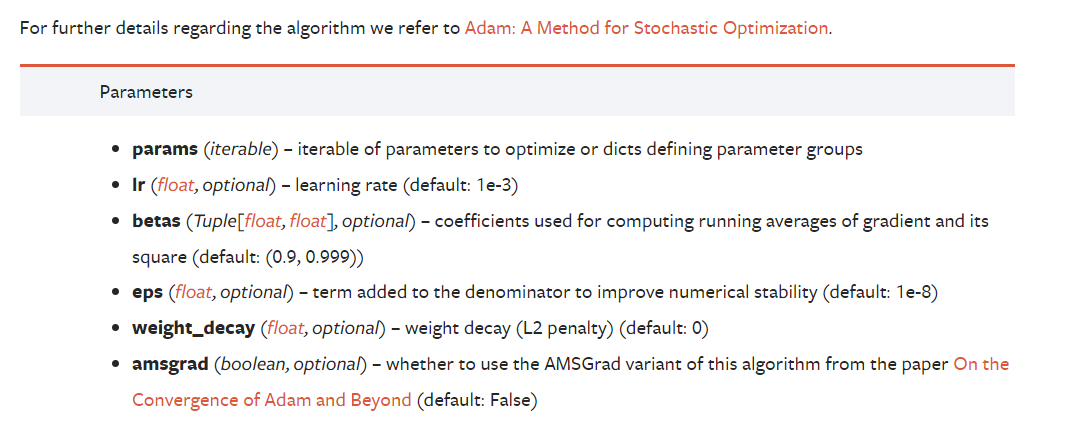

[출처] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

In [ ]:
losses = []

for epoch in range(100):

  for x, y in dataloader:
    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    #forward 연산
    hypothesis = model(x)

    #loss 계산
    y = y.squeeze()
    cost = loss(hypothesis, y)
    #역전파
    cost.backward()
    #parameter 업데이트
    optimizer.step()
    #값만 가져오기 위해서 .item()
  losses.append(cost.item())

  #10의 배수에 해당되는 에포크마다 비용을 출력
  if epoch %10 == 0:
      print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 0.7494566440582275
10 0.7294405102729797
20 0.7188915014266968
30 0.5514863133430481
40 0.5516260862350464
50 0.7567762136459351
60 0.5514597296714783
70 0.5514764785766602
80 0.5522871017456055
90 0.5514723062515259


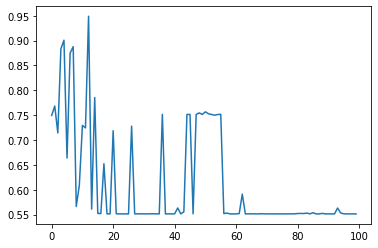

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

#gradient를 사용하지 않음
with torch.no_grad():

    model = model.to('cpu')
    X_test = torch.FloatTensor(X_test)
    y_pred = model(X_test)

    #tensor를 numpy로 바꿈
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis = 1)
    
    print(f'model의 output은 :  {y_pred[0]}' )
    print(f'argmax를 한 후의 output은 {predicted[0]}')

    #accuracy 확인
    accuracy = (accuracy_score(predicted,y_test))
    print(f'accuracy는 {accuracy}')

model의 output은 :  [7.743532e-11 1.000000e+00 7.743532e-11]
argmax를 한 후의 output은 1
accuracy는 0.9491525423728814


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
